## Installing Modules

In [ ]:
!pip install mediapipe
!pip install --upgrade diffusers[torch]
!pip install transformers
!pip install accelerate
!pip install git+https://github.com/huggingface/diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 22.1 MB/s eta 0:00:00
  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-hxbo4y8u
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-hxbo4y8u
  Resolved https://github.com/huggingface/diffusers to commit 3a7e481611bc299416aaeed4207086d9ddca5852
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.27.0.dev0-py3-none-any.whl size=1948688 sha256=5438a02ff4915ec39cd0804248a40b419213901a8056afc0be5c6b9d01eecbca
  Stored in directory: /tmp/pip-ephem-wheel-cache-b31y2agh/wheels/f7/7d/99/d361489e5762e3464b3811bc629e94cf5bf5ef44dd5c3c4d52
Successfully built diff

## Importing Modules

In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from google.colab.patches import cv2_imshow
import math
import numpy as np
from PIL import Image
from cv2 import kmeans, TERM_CRITERIA_MAX_ITER, TERM_CRITERIA_EPS, KMEANS_RANDOM_CENTERS
from numpy import float32
from matplotlib.pyplot import scatter, show
import matplotlib.pyplot as plt
import requests
from transformers import pipeline
import torch
import PIL
from diffusers import StableDiffusionInpaintPipeline, StableDiffusionControlNetInpaintPipeline, ControlNetModel, DDPMScheduler
from diffusers.utils import load_image
import torch

## Stable Diffusion ControlNet Pipeline Class

In [ ]:
# Stable Diffusion Controlnet Pipeline Class
class StableDiffusionControlnetPipeline:
  def __init__(self, PATH_IMG):
    self.PATH_IMG = PATH_IMG
    self.SELFIE_MULTICLASS_SEGMENTER_MODEL_PATH = "/content/selfie_multiclass_256x256.tflite"
    self.CONTROLNET_PATH = "lllyasviel/control_v11p_sd15_inpaint"
    self.MODEL_PATH = "Uminosachi/realisticVisionV51_v51VAE-inpainting"
    self.device = "cuda"

    #Loading the Hair Color Model from HugginFace
    self.hair_color_pipeline = pipeline("image-classification", model="enzostvs/hair-color")

    #Loading the ControlNet Inpaint Model from HugginFace
    self.controlnet = ControlNetModel.from_pretrained(
        self.CONTROLNET_PATH, torch_dtype=torch.float16
    ).to(self.device)

    #Loading the Stabel Difussion RealisticVision Inpaint Model from HugginFace
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        self.MODEL_PATH,
        controlnet=self.controlnet,
        safety_checker = None,
        requires_safety_checker = False,
        torch_dtype=torch.float16
    ).to(self.device)
    pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
    self.pipe = pipe

  #Function to Get the Principal Hair Color of the Image to pass it to the Prompt
  def get_hair_dominant_color(self) :
    hair_img = Image.open(self.PATH_IMG).convert('RGB')

    results = self.hair_color_pipeline.predict(hair_img)

    first_score, first_hair_color = results[0]["score"], results[0]["label"]
    second_score, second_hair_color = results[1]["score"], results[1]["label"]

    if first_hair_color != "completely bald" :
      return first_hair_color
    else :
      return second_hair_color

  def make_inpaint_condition(self, image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

  def roundUp(self, input, round) :
    return input + round - (input % round)

  # Function to Edit the Hair Roots of the Img with Stable Diffusion and ControlNet
  def stable_diffusion_controlnet(self) :
    HAIR_ROOT_MASK_PATH = self.create_hair_root_mask(self.PATH_IMG, self.SELFIE_MULTICLASS_SEGMENTER_MODEL_PATH)
    HAIR_COLOR = self.get_hair_dominant_color()

    PROMPT = f"({HAIR_COLOR} root:1.2), raw photo, high detail"
    NEGATIVE_PROMPT = "black hair root"

    init_image = load_image(self.PATH_IMG)
    mask_image = load_image(HAIR_ROOT_MASK_PATH)

    height = self.roundUp(init_image.height, 8)
    width = self.roundUp(init_image.width, 8)

    generator = torch.Generator(device=self.device).manual_seed(1)
    control_image = self.make_inpaint_condition(init_image, mask_image)

    new_image = self.pipe(prompt=PROMPT,
                  image=init_image,
                  mask_image=mask_image,
                  num_inference_steps=40,
                  generator=generator,
                  control_image=control_image,
                  negative_prompt=NEGATIVE_PROMPT,
                  strength=1,
                  height=height,
                  width=width,
                  padding_mask_crop=40,
                  guidance_scale=3.5
                  ).images

    hair_root_edited_img = new_image[0]
    hair_root_edited_img.save("new_img_modified.jpg")
    return hair_root_edited_img

  def view_result(self, init_image,touched_up_image):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    # Display Original Image
    axes[0].imshow(init_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

  # Display Hair Root Touched-up Image
    axes[1].imshow(touched_up_image)
    axes[1].set_title('Hair Root Touched-up')
    axes[1].axis('off')

    # Show plot
    plt.show()

  # Resizing and Showing the image
  def resize_and_show(self, image, INPUT_HEIGHT=512, INPUT_WIDTH=512):
    h, w = image.shape[:2]
    if h < w:
      img = cv2.resize(image, (INPUT_WIDTH, math.floor(h/(w/INPUT_WIDTH))))
    else:
      img = cv2.resize(image, (math.floor(w/(h/INPUT_HEIGHT)), INPUT_HEIGHT))
    cv2_imshow(img)

  #Function to Create the Hair Root Mask of the Image
  def create_hair_root_mask(self, PATH_IMG, SELFIE_MULTICLASS_SEGMENTER_MODEL_PATH) :
    BG_COLOR = (0, 0, 0) # Background RGB Color
    MASK_COLOR = (255, 255, 255) # Mask RGB Color
    HAIR_CLASS_INDEX = 1 #Index of the Hair Class
    N_CLUSTERS = 3

    img = cv2.imread(PATH_IMG)

    # Create the options that will be used for ImageSegmenter
    base_options = python.BaseOptions(model_asset_path=SELFIE_MULTICLASS_SEGMENTER_MODEL_PATH)
    options = vision.ImageSegmenterOptions(base_options=base_options,
                                          output_category_mask=True)

    # Creating the Hair Mask
    with vision.ImageSegmenter.create_from_options(options) as segmenter:
      # Loading Original Image
      image = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)

      # Retrieve the masks for the segmented image
      segmentation_result = segmenter.segment(image)
      category_mask = segmentation_result.category_mask

      # Generate solid color images for showing the output segmentation mask.
      image_data = image.numpy_view()
      fg_image = np.zeros(image_data.shape, dtype=np.uint8)
      fg_image[:] = MASK_COLOR
      bg_image = np.zeros(image_data.shape, dtype=np.uint8)
      bg_image[:] = BG_COLOR

      condition = np.stack((category_mask.numpy_view(),) * 3, axis=-1) == HAIR_CLASS_INDEX
      output_image = np.where(condition, fg_image, bg_image)

      #Saving the Hair Mask Image
      cv2.imwrite("hair_mask.png", output_image)

      #Cropping only the Hair Mask Area of the Original Image
      hair_mask_cropped = cv2.bitwise_and(img, output_image)

      # Changing the background color to gray
      coords = np.where(output_image != [255,255,255])
      background = np.full(img.shape, 128, dtype=np.uint8)  # gray background color

      # swaping the values of the image
      hair_mask_cropped[coords[0],coords[1],coords[2]] = background[coords[0],coords[1],coords[2]]

      #Saving the Hair Mask Cropped Image
      rgb_img_hair_mask_cropped = cv2.cvtColor(hair_mask_cropped, cv2.COLOR_BGR2RGB)
      pillow_img = Image.fromarray(rgb_img_hair_mask_cropped)

      pillow_img.save("hair_mask_cropped.jpg")

      # Reshape image to an Mx3 array
      img_data = rgb_img_hair_mask_cropped.reshape(-1, 3)

      # Specify the algorithm's termination criteria
      criteria = (TERM_CRITERIA_MAX_ITER + TERM_CRITERIA_EPS, 100, 0.2)

      # Run the k-means clustering algorithm on the pixel values
      compactness, labels, centers = kmeans(data=img_data.astype(float32), K=N_CLUSTERS, bestLabels=None, criteria=criteria, attempts=10, flags=KMEANS_RANDOM_CENTERS)

      # Apply the RGB values of the cluster centers to all pixel labels
      colours = centers[labels].reshape(-1, 3)

      # Reshape array to the original image shape
      img_colours = colours.reshape(rgb_img_hair_mask_cropped.shape)

      #Number of Each Label Class
      number_labels = np.bincount(labels.flatten())

      minimum_cluster_class = number_labels.argmin()

      # show the minimum_cluster_class (turn the pixel into white)
      masked_image = np.copy(rgb_img_hair_mask_cropped)

      # convert to the shape of a vector of pixel values
      masked_image = masked_image.reshape((-1, 3))

      labels = labels.flatten()

      masked_image[labels == minimum_cluster_class] = [255, 255, 255]

      # convert back to original shape
      masked_image = masked_image.reshape(rgb_img_hair_mask_cropped.shape)

      # show the minimum_cluster_class
      masked_image = np.copy(rgb_img_hair_mask_cropped)

      # convert to the shape of a vector of pixel values
      masked_image = masked_image.reshape((-1, 3))

      for i in range(0, len(number_labels)) :
        masked_image[labels == i] = [0, 0, 0]

      masked_image[labels == minimum_cluster_class] = [255, 255, 255]

      # convert back to original shape
      masked_image = masked_image.reshape(rgb_img_hair_mask_cropped.shape)

      #Saving the Hair Root Mask Image
      rgb_img_hair_root_mask = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
      pillow_img = Image.fromarray(rgb_img_hair_root_mask)

      pillow_img.save("hair_root_mask.jpg")

      hair_rost_mask_img = cv2.imread('/content/hair_root_mask.jpg')

      #Now convert the grayscale image to binary image
      gray = cv2.cvtColor(hair_rost_mask_img, cv2.COLOR_BGR2GRAY)
      ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

      #Now detect the contours
      contours, hierarchy = cv2.findContours(binary, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

      # draw contours on the original image
      image_copy = hair_rost_mask_img.copy()
      image_copy = cv2.drawContours(image_copy, contours, -1, (255, 255, 255), thickness=3, lineType=cv2.LINE_4)
      cv2.fillPoly(image_copy,pts=contours,color=(255,255,255))

      (h, w) = image_copy.shape[:2]

      cut_pixel = int((w//2) * 0.25)

      chin_point = ((w//2) - cut_pixel,(h//2) - cut_pixel)

      #Cropping the Image to only Focus in the Hair Root Area
      image_copy[chin_point[0]:,:] = [0,0,0]

      # saving the hair root image mask
      cv2.imwrite("hair_root_mask_mdf.png", image_copy)

      HAIR_ROOT_MASK_PATH = "/content/hair_root_mask_mdf.png"

      return HAIR_ROOT_MASK_PATH

## Set the IMG Path

In [ ]:
PATH_IMG = "/content/fsjlsss2.jpg"

## Creating the Instance of the StableDiffusionControlnetPipeline Class




In [ ]:
SB_ControlNet_pipeline = StableDiffusionControlnetPipeline(PATH_IMG)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/891 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/lora.py:384: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/models/lora.py:300: FutureWarning: `LoRACompatibleConv` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleConv` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleConv", "1.0.0", deprecation_message)


model_index.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Keyword arguments {'controlnet': ControlNetModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): LoRACompatibleLinear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): LoRACompatibleLinear(in_features=1280, out_features=1280, bias=True)
  )
  (controlnet_cond_embedding): ControlNetConditioningEmbedding(
    (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (blocks): ModuleList(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): Conv2d(32, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


## Showing the Image

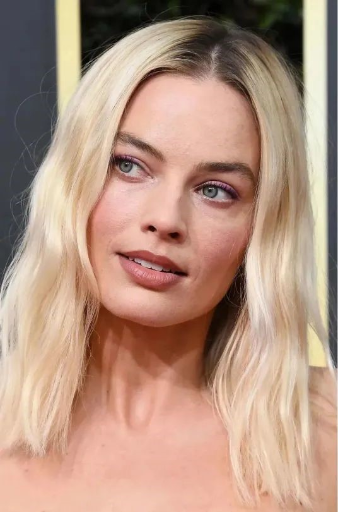

In [ ]:
initial_img = cv2.imread(PATH_IMG)

SB_ControlNet_pipeline.resize_and_show(initial_img)

## Calling the StableDiffusionControlnetPipeline

  0%|          | 0/40 [00:00<?, ?it/s]

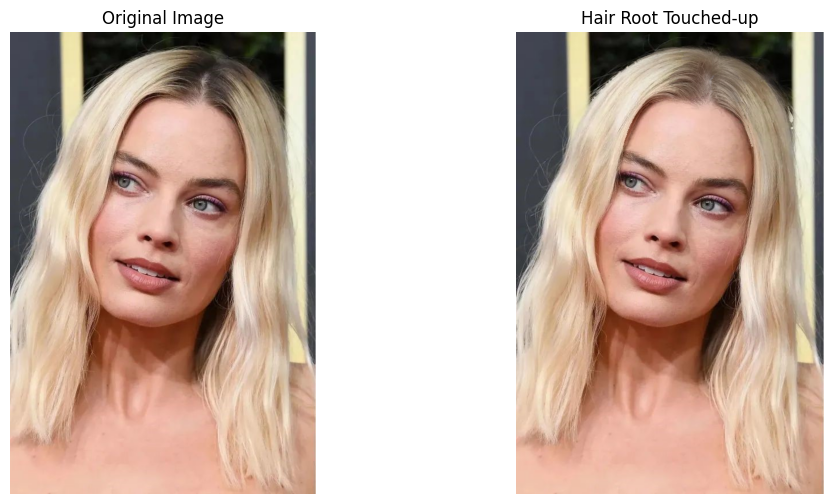

In [ ]:
#Obtaining the New Edited Hair Roots Image
hair_root_edited_img = SB_ControlNet_pipeline.stable_diffusion_controlnet()

# View the Result
initial_img = cv2.cvtColor(initial_img, cv2.COLOR_BGR2RGB)
SB_ControlNet_pipeline.view_result(initial_img, hair_root_edited_img)